# Sensor Offsets
This notebook contains experiments used in determining the best way to work out sensor offsets in a dataset. See [Github Issue #268](https://github.com/BjerknesClimateDataCentre/QuinCe/issues/268).

## Setup
We use a peak detection algorithm described in this [StackOverflow question](https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/56451135#56451135).

The sample data here has had bad data removed (there were a lot of spikes). This implies that the offset detection alorithm should be run *after* the sensor QC stage.

In [4]:
# Imports
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from math import floor
import sys

def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter[i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


## Load data

In [31]:
# Load TSG
tsg = pd.read_csv('TSG.csv', names=['Time', 'SST'])

# Load GO and make UNIX time colum
go = pd.read_csv('GO.tsv', sep='\t')

go['UNIXTime'] = go.apply(
    lambda row:
        int(datetime.timestamp(
            datetime.strptime(f'{getattr(row, "PC Date")} {getattr(row, "PC Time")}', '%d/%m/%Y %H:%M:%S'))),
        axis=1)

min_time = min(tsg['Time'])
if min(go['UNIXTime']) < min_time:
    min_time = min(go['UNIXTime'])
    
max_time = max(tsg['Time'])
if max(go['UNIXTime']) > max_time:
    max_time = max(go['UNIXTime'])

print(f'Minimum time: {min_time}')
print(f'Maximum time: {max_time}')

Minimum time: 1543618976
Maximum time: 1558552742


## Set Time Range

In [32]:
#time_start = 1547000000
#time_end = 1552000000

time_start = 1543618976
time_end = 1558552742

tsg_filtered = tsg.loc[(tsg['Time'] >= time_start) & (tsg['Time'] <= time_end)]
go_filtered = go.loc[(go['UNIXTime'] >= time_start) & (go['UNIXTime'] <= time_end)]

print(f'Select {len(tsg_filtered)}/{len(go_filtered)} values')

Select 918537/60815 values


## SST from TSG and EqT from GO

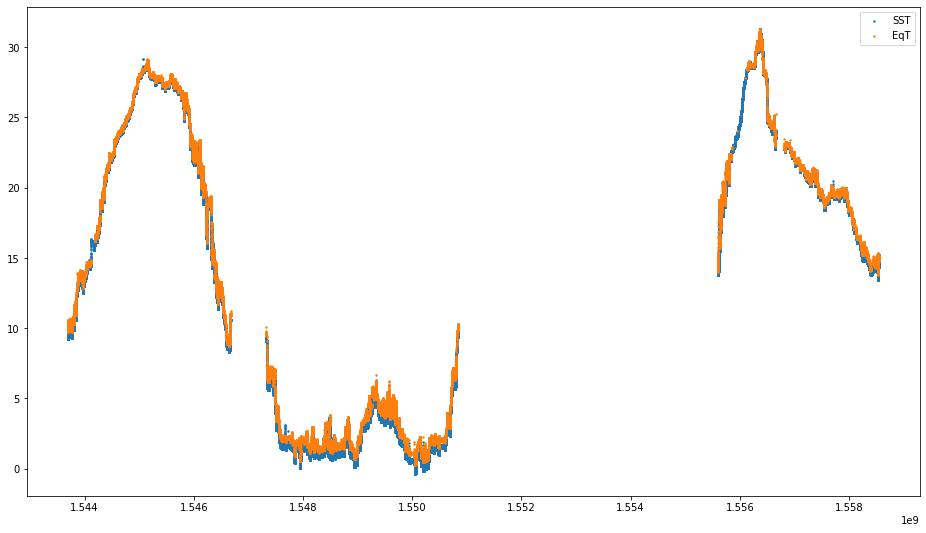

In [33]:
plt.figure(figsize=(16, 9))
plt.scatter(tsg_filtered['Time'], tsg_filtered['SST'], label='SST', s=2)
plt.scatter(go_filtered['UNIXTime'], go_filtered['equ temp'], label='EqT', s=2)
plt.legend()

## Set up peak detector
Set the parameters for the peak detection algorithm

|Parameter |Meaning                                                                        |
|----------|-------------------------------------------------------------------------------|
|lag       |The number of values to use in the moving average.                             |
|threshold |Signal threshold (in standard deviations from the moving average).             |
|influence |The influence of a signal as a fraction of the influence of normal data points.|

Because the two time series have different sampling rates, our lag is defined as a period of time, which is then converted to a number of measurements based on the mean spacing between measurements across each time series. For example, using our complete TSG dataset:

1. Target lag window: 1 day (86,400 seconds)
2. Number of measurements in TSG data set: 918,537
3. TSG measurement range: 2018-11-30 23:02:56 to 2019-05-22 20:19:02 (14,937,366 seconds)
4. Seconds per measurement: $\frac{14937366}{918537} = 16.26$ measurements per second
5. Lag size = $floor\left(\frac{86400}{16.26}\right) = 5313$ measurements

*Note that we assume that our measurements are regularly spaced. This is a good enough approximation for our needs.*

In [34]:
# Peak detector settings
DEFAULT_LAG_WINDOW = 86400
THRESHOLD=2.5
INFLUENCE=0.5

def calc_lag(times):
    value_count = len(times)
    time_range = times[len(times) - 1] - times[0]
    seconds_per_measurement = time_range / value_count
    
    lag_window = DEFAULT_LAG_WINDOW
    lag_size = floor(lag_window / seconds_per_measurement)
    while lag_size >= len(times):
        lag_window = floor(lag_window / 2)
        lag_size = floor(lag_window / seconds_per_measurement)
    
    return lag_size

## Run peak detector for SST and EqT

In [35]:
sst_lag_size = calc_lag(list(tsg_filtered['Time']))
print(sst_lag_size)
sst = list(tsg_filtered['SST'])
sst_peaks = thresholding_algo(sst, sst_lag_size, THRESHOLD, INFLUENCE)

eqt_lag_size = calc_lag(list(go_filtered['UNIXTime']))
print(eqt_lag_size)
eqt = list(go_filtered['equ temp'])
eqt_peaks = thresholding_algo(eqt, eqt_lag_size, THRESHOLD, INFLUENCE)

5339
351


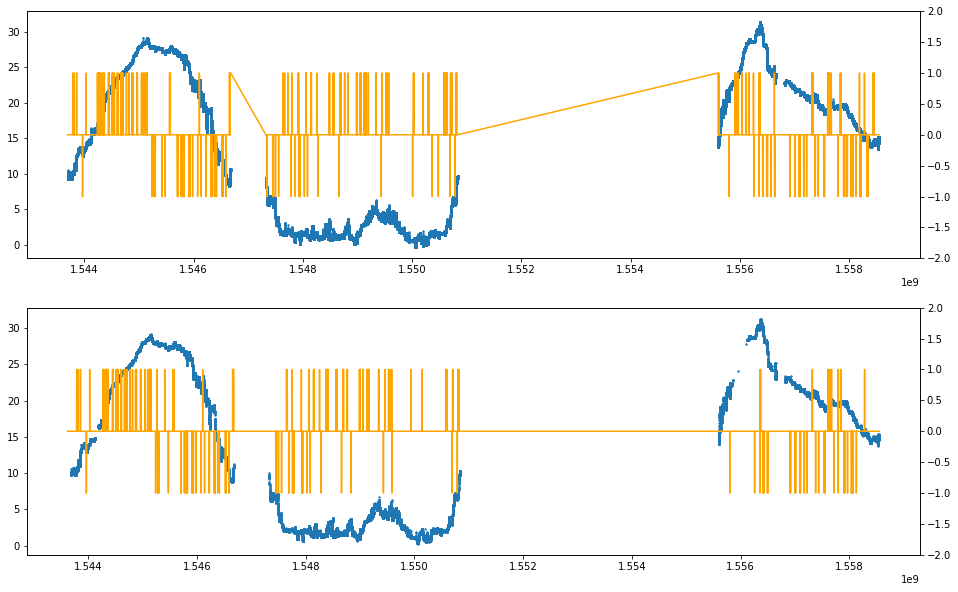

In [36]:
fig, (sst_ax, eqt_ax) = plt.subplots(2, figsize=(16, 10))

sst_ax.scatter(tsg_filtered['Time'], tsg_filtered['SST'], label='SST', s=2)
sst_ax2 = sst_ax.twinx()
sst_ax2.set_ylim(-2,2)
sst_ax2.plot(tsg_filtered['Time'], sst_peaks['signals'], color="orange")

eqt_ax.scatter(go_filtered['UNIXTime'], go_filtered['equ temp'], label='EqT', s=2)
eqt_ax2 = eqt_ax.twinx()
eqt_ax2.set_ylim(-2,2)
eqt_ax2.plot(go_filtered['UNIXTime'], eqt_peaks['signals'], color="orange")

## Extract peak positions
Find the places in each time series where the peaks series goes from zero to one (or -1). We exclude periods where the source time series contains NaNs **(not yet implemented)**.

In [37]:
def get_peak_positions(times, peaks):
    peak_positions = list()
    
    last_value = peaks[0]
    
    for i in range(1, len(peaks)):
        if peaks[i] != 0:
            if last_value == 0:
                peak_positions.append((times[i], int(peaks[i])))
    
        last_value = peaks[i]
        
    return peak_positions

sst_peak_positions = get_peak_positions(list(tsg_filtered['Time']), sst_peaks['signals'])
eqt_peak_positions = get_peak_positions(list(go_filtered['UNIXTime']), eqt_peaks['signals'])

print(f'SST peak count: {len(sst_peak_positions)}')
print(f'EqT peak count: {len(eqt_peak_positions)}')

SST peak count: 696
EqT peak count: 235


## Calculate offsets
Offsets are calculated using two lists of peak positions: the `base_list` and the `adjust_list`. For SST and EqT we adjust the EqT to match the SST. Since SST is physically before EqT in the instrument, all adjustments must be backwards in time. We apply a maximum distance threshold to adjustments to prevent accidental unrealistic adjustments if the peaks don't line up particularly well at certain times.

We loop through the `adjust_list` peak positions. For each of these we find the closest entry in the `base_list` that is:

- before the `adjust_list` peak
- in the same direction as the peak (up or down)
- within the maximum time limit

If there is a match we record the difference in times of the `before_list` and `adjust_list` peaks as the offset. If any two `adjust` values try to adjust to the same `base` value, we only accept the first one to ensure that regions of the `adjust` time series don't collapse into a black hole type situation.

In [38]:
def make_offsets(base_list, adjust_list, max_difference=600):

    adjustments = list()
    
    # Keep track of where we are in the base list
    base_index = -1
    base_index_used = False
    
    # Loop through each peak in the adjust list
    for (pos, direction) in adjust_list:
        # Find the last base entry before the adjust entry
        while base_index < len(base_list) - 1 and base_list[base_index + 1][0] < pos:
            base_index += 1
            base_index_used = False
            
        # Check that the peak is within the limit and in the same direction
        if not base_index_used and base_list[base_index][1] == direction:

            offset = base_list[base_index][0] - pos
            if abs(offset) <= max_difference:
                adjustments.append((pos, offset))
                base_index_used = True
            
    return adjustments

eqt_offsets = make_offsets(sst_peak_positions, eqt_peak_positions, max_difference=600)

# Extend the first and last offsets to the start and end of the full timeseries
eqt_offsets.insert(0, (list(go_filtered['UNIXTime'])[0], eqt_offsets[0][1]))
eqt_offsets.append((list(go_filtered['UNIXTime'])[len(go_filtered) - 1], eqt_offsets[len(eqt_offsets) - 1][1]))


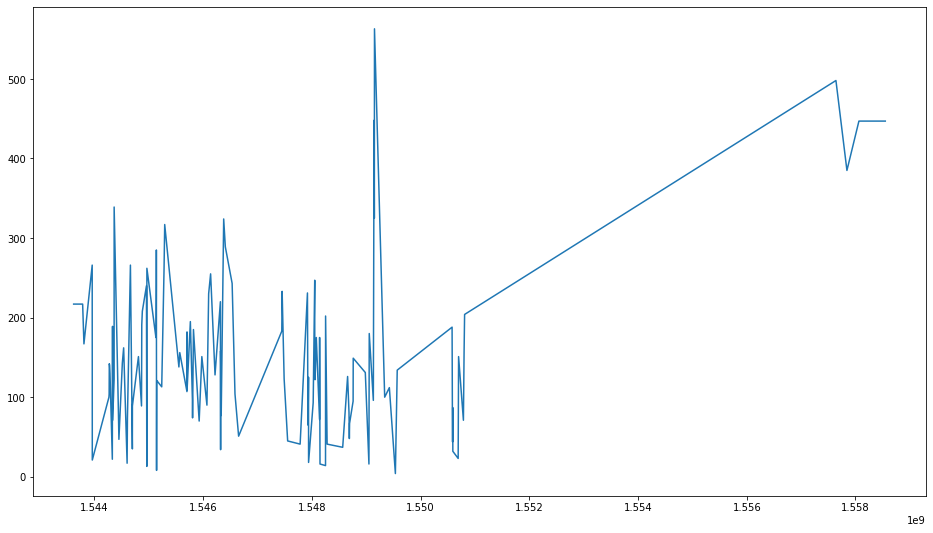

In [39]:
offset_times = [x[0] for x in eqt_offsets]
offset_amounts = [x[1] * -1 for x in eqt_offsets]

plt.figure(figsize=(16, 9))
plt.plot(offset_times, offset_amounts)


## Further Adjustments
We shouldn't interpolate the offset across the large NaN gaps - we should treat each gap as its own start/end point. This is easily achieved by extrapolating the first/last offset of each section to the start/end of that section, as we do for the whole time series. We need to determine the definition of a long gap - maybe some function of the average time between offset adjustments?